In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from bs4 import BeautifulSoup
import random
import string
from collections import Counter
import jieba.posseg as pseg




# 数据来源：  
1.Wang, Y., Yang, W., Ma, F., Xu, J., Zhong, B., Deng, Q., & Gao, J. (2020). Weak Supervision for Fake News Detection via Reinforcement Learning. Proceedings of the AAAI Conference on Artificial Intelligence, 34(01), 516-523.

后面分析发现都是来自微信公众号平台

网页：

# 数据统计

In [19]:
"""文档读取csv文件"""
data = pd.read_csv('./train/train.csv')
data.head()

,id,Ofiicial Account Name,Title,News Url,Image Url,Report Content,label
0,0,朝阳实拍,范冰冰出轨被偷拍？这才是真相！,http://mp.weixin.qq.com/s?__biz=MzI1NzIzNDkxNQ...,http://mmbiz.qpic.cn/mmbiz_jpg/XUUcJo9yhYRlbzt...,发布误导信息,1
1,1,文刊,马容竟然去了非诚匆扰，一出场24盏灯全灭，孟爷爷都笑了,http://mp.weixin.qq.com/s?__biz=MzUxODE2MDMwMQ...,https://mmbiz.qlogo.cn/mmbiz_jpg/X3Cv4sIxE7Bib...,标题与内容不符##骗点击##欺骗阅读者。,1
2,2,掌上武冈,突发：武冈西站木材市场燃起大火，浓烟滚滚火势巨大，现场...,http://mp.weixin.qq.com/s?__biz=MzAwMjM0NzMxOA...,https://mmbiz.qlogo.cn/mmbiz_jpg/fnLwjhfLVGZQK...,报道内容不实，描述事实也不食,0
3,3,时事内幕爆料,辞职交警!爆`出贪 污惊人内幕！99%车主都不知道！速看,http://mp.weixin.qq.com/s?__biz=MzU3NjIzNTI5OA...,https://mmbiz.qlogo.cn/mmbiz_jpg/hYnJtOcFjEhV0...,谣言！##不实,0
4,4,大参考,美国两块让国人汗颜的告示牌，告诉我们离文明有多远,http://mp.weixin.qq.com/s?__biz=MzA5MDE4NTY4Mw...,http://mmbiz.qpic.cn/mmbiz_jpg/T0OtTToYoIR77vL...,虚假宣传##以偏概全,0


In [20]:
"""数据信息"""
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10587 entries, 0 to 10586
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     10587 non-null  int64 
 1   Ofiicial Account Name  10585 non-null  object
 2   Title                  10587 non-null  object
 3   News Url               10587 non-null  object
 4   Image Url              10587 non-null  object
 5   Report Content         10587 non-null  object
 6   label                  10587 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 579.1+ KB


In [21]:
"""读取单个html"""
# with open('./train/html/0.html', encoding='utf-8') as f:
#     html = f.read()
#     print(html)

'读取单个html'

In [22]:
"""真假新闻个数, 虚假新闻占比"""
data['label'].value_counts(), f"{data['label'].value_counts()[1]/data['label'].value_counts()[0]:.6f}"

(label
 0    7844
 1    2743
 Name: count, dtype: int64,
 '0.349694')

In [23]:
"""是否都是来自微信公众号"""
data.count(), data['News Url'].str.contains('mp.weixin.qq.com').value_counts()


(id                       10587
 Ofiicial Account Name    10585
 Title                    10587
 News Url                 10587
 Image Url                10587
 Report Content           10587
 label                    10587
 dtype: int64,
 News Url
 True    10587
 Name: count, dtype: int64)

# html分析

In [24]:
"""html文件读取"""

html_list = []
for i in tqdm(range(data.shape[0])):
    with open("./train/html/{}.html".format(i), encoding='utf-8') as f:
        html = f.read()
        html_list.append(html)
html_list = pd.Series(html_list)
html_list.head()

100%|██████████| 10587/10587 [00:13<00:00, 808.90it/s]


0    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
1    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
2    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
3    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
4    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
dtype: object

In [25]:
"""html文件长度"""
html_lengths = list(html_list.apply(lambda x: len(x)))
html_lengths_pd = pd.DataFrame(html_lengths, columns=['html_lenths'])
print("info:", html_lengths_pd.info())
print("describe:\n", html_lengths_pd.describe())
print("众数及其数量:\n", html_lengths_pd.mode())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10587 entries, 0 to 10586
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   html_lenths  10587 non-null  int64
dtypes: int64(1)
memory usage: 82.8 KB
info: None
describe:
          html_lenths
count   10587.000000
mean   178249.129876
std    252367.988048
min     17690.000000
25%     27555.000000
50%     27876.000000
75%    572228.500000
max    944942.000000
众数及其数量:
    html_lenths
0        27555


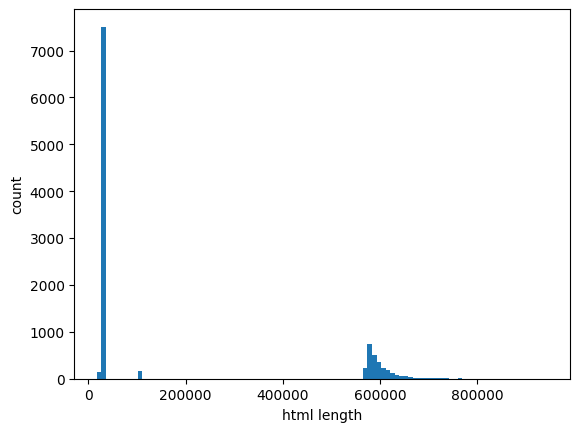

In [26]:
"""html文件长度分布图"""
plt.hist(html_lengths, bins=100)
plt.xlabel('html length')
plt.ylabel('count')
plt.show()


In [27]:
html_lengths_pd[html_lengths_pd['html_lenths'] < 200000].index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       10568, 10569, 10571, 10573, 10575, 10576, 10577, 10581, 10582, 10585],
      dtype='int64', length=7834)

In [28]:
"""筛选html文件长度小于200000的,并得到序号"""
shortlen_html_pd = pd.DataFrame(html_lengths_pd[html_lengths_pd['html_lenths'] < 200000],
                                index = html_lengths_pd[html_lengths_pd['html_lenths'] < 200000].index)
print(shortlen_html_pd.describe())
print(shortlen_html_pd.value_counts())

         html_lenths
count    7834.000000
mean    29196.990809
std     11133.430110
min     17690.000000
25%     27555.000000
50%     27555.000000
75%     28016.000000
max    102502.000000
html_lenths
27555          4054
27673           581
28016           471
28053           362
27251           352
               ... 
24312             1
28089             1
29679             1
29519             1
27340             1
Name: count, Length: 120, dtype: int64


# text分析

In [29]:
"""通过utf-8编码将html文件中的文字和汉字符号部分提取出来"""
number = [n for n in string.digits]
chinese_symbol = ['。', '，', '！', '？', '；', '：', '“', '”', '‘', '’', '（', '）', '《', '》', '、', '…', '—', '【', '】']
text_list = []
for html in tqdm(html_list):
    soup = BeautifulSoup(html)
    chinese_text = ''.join(soup.stripped_strings)
    chinese_text = [char for char in chinese_text if '\u4e00' <= char <= '\u9fff' or char in chinese_symbol or char in number]
    text_list.append(''.join(chinese_text))


100%|██████████| 10587/10587 [01:03<00:00, 167.03it/s]


In [30]:
"""浏览"""
def showText(text_list):
    for i in range(100):
        index = random.randint(0, len(text_list))
        print(index, '\t', text_list[index])
showText(text_list)

3440 	 该内容已被发布者删除微信公众平台运营中心：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看分享留言收藏
7911 	 此内容因违规无法查看由用户投诉并经平台审核，涉嫌过度营销、骚扰用户，查看对应规则我要反馈微信公众平台运营中心：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看分享留言收藏
7782 	 该内容已被发布者删除微信公众平台运营中心：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看分享留言收藏
3494 	 该内容已被发布者删除微信公众平台运营中心：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看分享留言收藏
9309 	 此账号已被屏蔽内容无法查看接相关投诉，此账号涉嫌违反《互联网用户公众账号信息服务管理规定》，查看详细内容：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看分享留言收藏
3993 	 基层民警：张磊案的判决是压倒中国警察的最后一根稻草张迟有度连之无诈2013年6月，贵州省遵义市中级人民法院以民警张磊在受到暴力袭击时，使用武器致人死亡，属于防卫过当构成故意杀人犯罪，判决有期徒刑八年。判决后，对判决的质疑一直不断。最近这个案件又不断出现在各种自媒体中，再次细细的研读了判决书，有感而生，“当法律不能去保护依法履职的警察时，受到伤害的不光是警察本身，更大的受害者是理应受到警察保护的人民群众”。这个判决不到8个月时间，2014年3月1日，昆明车站，当暴徒持刀在屠杀无辜群众时，到场警察不敢击毙行凶份子，只是向天鸣枪。向天鸣枪，浪费完了宝贵的子弹，对份子没有一点用处，警察也被砍伤了。也许这些分子在培训怎么屠杀时，被告知警察是不会用枪打人的。当巡警到场时，一只突击步枪，五六秒钟就击毙击伤了所有的分子，最终还是现代化武器结束了这场震惊世界的事件。开枪巡警事后接受受记者采访时说，开完枪，心里很紧张，不知会不会因为开枪受到追究，但是后来看到满地的尸体，才放下心来。几个分子，使用冷兵器，在这么短的时间内屠杀了那么多的人，这也许是另一种可悲的中国特色。警察不敢开枪打分子，更是中国警察，中国人民的可悲特色。最先到场的警察，也是很勇敢的，打光子弹，还在和分子搏斗，自己也英勇的受伤。如果这个警察敢开枪击毙分子，有多少无辜的群众不会成为冤魂？警察不敢依法使用武器去保护人民，保护自己，到底是谁的错？昆明车站警察不敢击毙分子，导致更

In [31]:
"""数据清洗，将无用的语句、信息删除"""

dirty_words = ["：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看",
               "分享留言收藏",
               "向上滑动看下一个知道了微信扫一扫使用小程序取消允许取消允许分析",
               "预览时标签不可点微信扫一扫关注该公众号继续滑动看下一个轻触阅读"
               ]
for index, test in enumerate(text_list):
    for dirty_word in dirty_words:
        text_list[index] = text_list[index].replace(dirty_word, '')
showText(text_list)


1966 	 该内容已被发布者删除微信公众平台运营中心
9194 	 该内容已被发布者删除微信公众平台运营中心
6933 	 此账号已被屏蔽内容无法查看接相关投诉，此账号涉嫌违反《互联网用户公众账号信息服务管理规定》，查看详细内容
5740 	 该内容已被发布者删除微信公众平台运营中心
942 	 此账号已被屏蔽内容无法查看由用户投诉并经平台审核，使用煽动、误导、违背客观事实的文字、图片、视频等，捏造社会热点、歪曲历史事件、混淆公众视听，查看对应规则我要申诉微信公众平台运营中心
841 	 该内容已被发布者删除微信公众平台运营中心
8998 	 该内容已被发布者删除微信公众平台运营中心
4031 	 此账号已自主注销，内容无法查看
8792 	 此账号已被屏蔽内容无法查看接相关投诉，此账号涉嫌违反《互联网用户公众账号信息服务管理规定》，查看详细内容
3468 	 此账号已被屏蔽内容无法查看由用户投诉并经平台审核，涉嫌违反相关法律法规，查看对应规则我要申诉微信公众平台运营中心
415 	 此账号已被屏蔽内容无法查看由用户投诉并经平台审核，涉嫌欺诈，查看对应规则我要申诉微信公众平台运营中心
4766 	 该内容已被发布者删除微信公众平台运营中心
2284 	 该内容已被发布者删除微信公众平台运营中心
8265 	 该内容已被发布者删除微信公众平台运营中心
10169 	 此账号已被屏蔽内容无法查看由用户投诉并经平台审核，涉嫌违反相关法律法规，查看对应规则我要申诉微信公众平台运营中心
9966 	 此账号已被屏蔽内容无法查看由用户投诉并经平台审核，存在过度营销、骚扰用户行为，查看对应规则我要申诉微信公众平台运营中心
2687 	 此账号已被屏蔽内容无法查看由用户投诉并经平台审核，存在过度营销、骚扰用户行为，查看对应规则我要申诉微信公众平台运营中心
7303 	 该内容已被发布者删除微信公众平台运营中心
7127 	 该内容已被发布者删除微信公众平台运营中心
1106 	 丢人！跳广场舞比“分贝”，大村镇男子王某对他人大打出手被刑拘……齐林新徐秀江岛城之声8月14日，青岛西海岸新区的男子王某（男，48岁）因故意伤害他人被黄岛警方依法刑事拘留，而这起案件竟然是因跳广场舞所引起的。今年5月30日的晚上，青岛西海岸新区大村镇理务关村中心广场上，有两拨村民在跳广场舞，他们各自占据广

In [32]:
"""保存test_list"""
text_path = "./train/text"
if not os.path.exists(text_path):
    os.makedirs(text_path)
for i, text in tqdm(enumerate(text_list)):
    with open(text_path + f'/{i}.txt', 'w', encoding='utf-8') as f:
        f.write(text + '\n')

10587it [00:04, 2523.76it/s]


In [33]:
"""被删除的文章的数量"""

dirty_key_words = ['此内容因违规无法查看', '该内容已被发布者删除', '此账号已被屏蔽内容无法查看',
                   '此账号已自主注销', '原账号迁移时未将文章素材同步至新账号','参数错误']
dirty_id = [i for i, x in enumerate(text_list) for del_key_word in dirty_key_words if del_key_word in x or x == '']
right_id = [i for i in range(data.shape[0]) if i not in dirty_id]
print(len(dirty_id)+len(right_id))
del_count = len(dirty_id)
print(del_count, f"{del_count/len(text_list):.6f}")

11297
8465 0.799566


In [34]:
"""查看没有被删除和没删除的文章"""
right_text = [text_list[i] for i in right_id]
dirty_text = [text_list[i] for i in dirty_id]
showText(right_text)
print("------------------")
showText(dirty_text)

1925 	 史上最难！9月起处理违章需【实名绑定刷脸】！很急！土豪也没辙！掌车宝车主服务9月起，办理非本人车辆交通违法须先“实名绑定”，此外还要“刷脸比对”！这意味着什么？处理扣分违章将“史上最难”！以后谁开车违法被扣分，只能谁去刷脸处理，没人能帮得了！还有违章未处理咋办？马上！立刻！赶紧！拖多一天都可能会“扑街”！掐指一算，不到10个工作日了！？趁还能找其他渠道“躺办”，早处理早安心。谁说来不及了？老子就爱拖到最后几天！兄弟你第一天开车吧？办违章要多久你心里没点数吗！再说大家都想拖到最后几天，到头来你分再多也得跪！我傻啊还用自己去排队？最后几天找朋友帮忙妥妥的！天真啊，来看看广东某处交管所，上班时间有成百上千人办理业务，加强管制后或许就门可罗雀了，自助智能化办理车业务的时代来临能帮你跑腿的还有谁？郑重提醒，高峰期交警系统崩溃也是可能的事，系统升级再拖上几天，恭喜你！麻烦9月后再来！别人此前开你车造成的违章，也全部记入车主你的名下，只能扣你自己的分！解读一、9月交通违法处理新规9月1日起，在线上或自助终端处理非本人名下机动车交通违法，必须先实名注册并绑定对应车辆，否则不能处理。新规带来的两个重要变化就是：1、不能随意帮朋友处理违章了，同理，你朋友也不能随意帮你处理违章了，毕竟绑定车辆有数量上的限制；非本人机动车绑定不超过3辆；累计绑定非本人机动车不得超过5辆（一证五车）；同一机动车最多同时被3个用户绑定（一车三证）。2、实名注册并绑定对应车辆后，只能处理绑定之后产生的交通违法，实名绑定以前的违章都不能处理。解读二、“人脸识别系统”将全国推广早在2017年8月，公安部交通管理局就下发了《关于严格道路交通安全违法行为处理坚决遏制买分卖分行为的通知》，通知中指出，各地在2018年9月1日前，要配齐人脸识别系统。前段时间有些地方交通罚款机暂停使用了，因为要进行系统升级，加装人脸识别功能。这就意味着自助渠道也在逐步开始应用“刷脸”功能。“刷脸”系统在国内早有应用，这一次的应用将更加智能化，其中一个常见的应用场景就是：去交管所处理扣分违章时，进入大厅和处理交通违法都要“刷脸”认证，确保是驾驶员本人处理。也就是说，车主处理违章通过刷脸才能进入扣分区域，杜绝代扣分人员和“黄牛”。想要蒙混过关？对不起！扣分人和驾驶员人脸识别相似度达不到百分之70以上，无法完成办理！或许你还有疑问：

In [35]:
"""保存没有被删除的文章到right_text文件夹中"""
right_path = "./train/right_text"
if not os.path.exists(right_path):
    os.makedirs(right_path)
for i, text in tqdm(zip(right_id, right_text)):
    with open(right_path + f'/{i}.txt', 'w', encoding='utf-8') as f:
        f.write(text)
"""保存没有删除的文章到dirty_text文件夹中"""
dirty_path = "./train/dirty_text"
if not os.path.exists(dirty_path):
    os.makedirs(dirty_path)
for i, text in tqdm(zip(dirty_id, dirty_text)):
    with open(dirty_path + f'/{i}.txt', 'w', encoding='utf-8') as f:
        f.write(text)


2832it [00:01, 2388.73it/s]
8465it [00:03, 2813.50it/s]


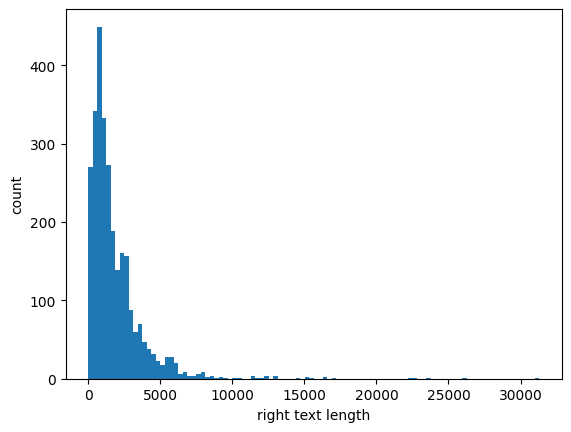

In [36]:
"""没有被删除的text文件长度分布图"""
plt.hist([len(x) for x in right_text], bins=100)
plt.xlabel('right text length')
plt.ylabel('count')
plt.show()


In [37]:
"""查看被删除的文章为虚假新闻的概率"""
del_fake_count = sum(1 for value in data['label'][dirty_id] if value == 1)
print(del_fake_count, f"{del_fake_count/del_count:.6f}")


2571 0.303721


In [38]:
"""查看未被删除的文章为虚假新闻的概率"""
right_count = sum(1 for value in data['label'][right_id] if value == 1)
print(right_count, f"{right_count/len(right_id):.6f}")

322 0.113701


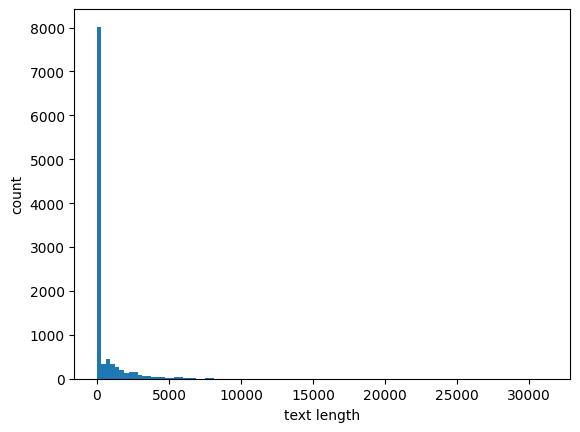

In [39]:
"""text文件长度分布图"""
plt.hist([len(x) for x in text_list], bins=100)
plt.xlabel('text length')
plt.ylabel('count')
plt.show()


In [40]:
"""text文件长度"""
text_lenths = [len(x) for x in text_list]
text_lenths_pd = pd.DataFrame(text_lenths, columns=['text_lenths'])
print("info:", text_lenths_pd.info())
print("describe:\n", text_lenths_pd.describe())
print("众数:\n", text_lenths_pd.mode())
print(text_lenths_pd.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10587 entries, 0 to 10586
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   text_lenths  10587 non-null  int64
dtypes: int64(1)
memory usage: 82.8 KB
info: None
describe:
         text_lenths
count  10587.000000
mean     525.010673
std     1341.227423
min        0.000000
25%       20.000000
50%       52.000000
75%      196.500000
max    31288.000000
众数:
    text_lenths
0           20
text_lenths
20             4059
52              708
59              551
56              361
15              352
               ... 
2034              1
2038              1
690               1
2046              1
31288             1
Name: count, Length: 1586, dtype: int64


# 特征提取

剔除被删除的文章丢弃，得到可用于训练的数据集，也就是剩下的right_id所对应的文章rifht_text，进行特征提取。

In [41]:
for i in range(10):
    print(right_text[i])

一年后退役！韦德作出最后决定终老热火！原创柚子柚子说球有时候有些消息就是这么悄无声息在我们所有人都还沉浸在甜瓜签约正要为休赛期的这个节点松一口气联盟最后一个悬念也紧接着揭晓了韦德在今天正式宣布他的未来决定可能是正在办理离职手续应接不暇这次的重磅消息轮到了爆料“韦德将与热火队续约一年继续征战，并且在下赛季结束之后选择退役！”韦大爷的最后一个赛季！韦德的动态也基本验证了这个消息他刚刚在社交媒体上发布了照片晒出自己与热火队友们训练的合照“和兄弟们一起训练！老流氓，没有牙的，黄金手臂以及我认识的最酷的人！”而詹姆斯约翰逊的配文则是：是“我们”永远不会是“他们”！这消息来得太快柚子还没能反应我们很高兴能够看见韦德重返热火再次身披3号战袍为迈阿密打拼相信这是韦德一直以来都想要的结局留在迈阿密是他从来不曾动摇的决定我们都知道浙江队曾经开出过3年2500万美元的天价希望韦德能够选择前往中国打球虽然浙江也表示自己明白这机会很小但是就是这么一点机会他们也要试试而韦德在作出最终决定之前就委婉的拒绝了来自中国的邀请他明确地对媒体表示自己还没有决定但是如果自己选择继续征战赛场的话一定会是身披热火的战袍没有别的可能同时他也解释了自己为什么拒绝在接受迈阿密当地媒体采访时他表示“我在中国有自己的品牌，如果我去那里打球会是个非常好的决定，但是家庭因素成为了我放弃的关键原因我儿子正在上高中，我想陪伴他，我要给他所有一切可能的支持现在我要为了家庭留在迈阿密不论我是否选择退役。”韦德的回归固然是一件好事每一位他的球迷都渴望再次目睹那个3号闪电侠继续在赛场驰骋只可惜这是闪电侠的最后一个赛季了这一个赛季的打拼和较量过后我们称呼韦德的方式将不是热火队员而是“迈阿密之魂，热火名宿韦德”忆往昔峥嵘岁月单枪匹马直捣黄龙闪电侠带给我们无数的经典瞬间他将自己书写进了名人堂之中也把自己刻进了球迷们的心里当年霸气劈扣瓦莱乔如今依旧高呼“这是我的马！”我们只希望这一切都不是真的柚子只想看见这条新闻的前半段但是如果这是千真万切的结局改不了的我们只能更加珍惜韦德在的最后一个赛季！——如果你喜欢我的文章可以关注微信公众号柚子说球预览时标签不可点阅读原文微信扫一扫关注该公众号继续滑动看下一个轻触阅读原文柚子说球
著名主持人朱军被爆性骚扰实习女生！泗州文艺昨天，新浪微博百万粉丝大罗昌平发微博，内容为某匿名网友发长文控诉央视名主持朱军对自

In [42]:
usable_train = data.iloc[right_id]
unusable_train = data.iloc[dirty_id]
# 保存
with open("./train/usable_train.csv", 'w', encoding='utf-8') as f:
    usable_train.to_csv(f, index=False)
with open("./train/unusable_train.csv", 'w', encoding='utf-8') as f:
    unusable_train.to_csv(f, index=False)
# 保存label为1的数据
with open("./train/usable_train_fake.csv", 'w', encoding='utf-8') as f:
    usable_train[usable_train['label'] == 1].to_csv(f, index=False)
# 保存label为0的数据
with open("./train/usable_train_real.csv", 'w', encoding='utf-8') as f:
    usable_train[usable_train['label'] == 0].to_csv(f, index=False)

usable_train.head(10)
    

,id,Ofiicial Account Name,Title,News Url,Image Url,Report Content,label
10,10,柚子说球,一年后退役！韦德作出最后决定终老热火！,http://mp.weixin.qq.com/s?__biz=MzIxOTI5NTk5MQ...,http://mmbiz.qpic.cn/mmbiz_jpg/6sMnWYZVWaR85gd...,未经证实散步韦德退役谣言,0
11,11,泗县城市网,著名主持人朱军被爆性骚扰实习女生！,http://mp.weixin.qq.com/s?__biz=MzIxMzAyNzU5NQ...,http://mmbiz.qpic.cn/mmbiz_jpg/qtGJibt7gqfPS4V...,未经证实,1
16,16,女神生活街,郑恺新恋情曝光，将和他携手退出跑男？网友：迪丽热巴暗讽看真相,http://mp.weixin.qq.com/s?__biz=MzIyODUzNjk5MA...,http://mmbiz.qpic.cn/mmbiz_jpg/ayhEAOFHVILicQD...,毫无根据，言语混乱,1
17,17,房里房外,台前县吴坝镇黄河滩区迁建成果初现，街亮了，家新了，腰包鼓了，昔日穷滩区，今日新城镇，国家扶贫...,http://mp.weixin.qq.com/s?__biz=MzA4NjQ1OTY0OA...,http://mmbiz.qpic.cn/mmbiz_jpg/92LsX90lExTEwuO...,我们不是滩区，为什么拆我们的房子。老百姓越来越穷，搬不起。##这个发表文章记者认识他受贿，他...,0
18,18,海门大神,@所有海门人！海门各乡镇微信群开通了！现邀请您来一起噶闹忙咯！！！,http://mp.weixin.qq.com/s?__biz=MzU5MzA0NTQzNw...,http://mmbiz.qpic.cn/mmbiz_jpg/ZibsiaicPwOia7i...,各群都是无聊退应该取缔,0
20,20,参考消息,德媒：被中国打中“七寸” 美国农民对贸易争端失去耐心,http://mp.weixin.qq.com/s?__biz=MjM5MzA0MTg2MA...,http://mmbiz.qpic.cn/mmbiz_jpg/F1hLEK71icuAQkk...,你没有你吹牛逼那么强大,0
22,22,爱临汾,忻州中西医结合医院造假大量骗取医保资金,http://mp.weixin.qq.com/s?__biz=MzU0MTcyMjg4MQ...,http://mmbiz.qpic.cn/mmbiz_jpg/gypEaBqfcibXQKw...,不实信息##不实信息,0
23,23,科技犬,卓伟爆料！某女星同侍父子俩，网友脑洞大开，上演名侦探柯南！,http://mp.weixin.qq.com/s?__biz=MzIwNDMyNTk0Ng...,http://mmbiz.qpic.cn/mmbiz_jpg/M4RkZsDvOoGyCJ7...,标题与内容严重不符,1
28,28,嘿星期八,别在危险的边缘试探噢,http://mp.weixin.qq.com/s?__biz=MzUzMjk0MzQyOA...,http://mmbiz.qpic.cn/mmbiz_jpg/IrQdFP8BsWUlNmV...,文中说潮州交通很乱，这点本地人不承认,0
31,31,潍坊论坛,定了！潍坊划入“青岛圈”！,http://mp.weixin.qq.com/s?__biz=MjM5MDA0MzA0Nw...,http://mmbiz.qpic.cn/mmbiz_jpg/b3GzIor9icsO0Tu...,谣言吧,0


In [43]:
"""文本长度 length"""
text_length = pd.Series([text_lenths[i] for i in right_id])
text_length
"""标题长度 title_length"""
title_length = pd.Series([len(data['Title'][i]) for i in right_id])
title_length

0       19
1       17
2       30
3       62
4       33
        ..
2827     9
2828    25
2829    30
2830    25
2831    25
Length: 2832, dtype: int64

In [44]:
"""引号、感叹号、问号引用比率 quote_symbol_rate strong_emotion_symbol_rate"""
symbol_count = []
for text in right_text:
    symbol_count.append(sum(1 for char in text if char in chinese_symbol))
symbol_count = pd.Series(symbol_count)

quote_symbol_count = []
for text in right_text:
    quote_symbol_count.append(sum(1 for char in text if char == '“' or char == '”'))
quote_symbol_count = pd.Series(quote_symbol_count)

strong_emotion_symbol_count = []
for text in right_text:
    strong_emotion_symbol_count.append(sum(1 for char in text if char == '！' or char == '？'))
strong_emotion_symbol_count = pd.Series(strong_emotion_symbol_count)

quote_symbol_rate = quote_symbol_count / symbol_count + 1e-6
strong_emotion_symbol_rate = strong_emotion_symbol_count / symbol_count + 1e-6

# 归一化
quote_symbol_rate = (quote_symbol_rate - quote_symbol_rate.min()) / (quote_symbol_rate.max() - quote_symbol_rate.min())
strong_emotion_symbol_rate = (strong_emotion_symbol_rate - strong_emotion_symbol_rate.min()) / (strong_emotion_symbol_rate.max() - strong_emotion_symbol_rate.min())

print(quote_symbol_rate.head())
print(strong_emotion_symbol_rate.head())

0    0.496296
1    0.000000
2    0.145969
3    0.000000
4    0.000000
dtype: float64
0    0.257143
1    0.086957
2    0.264706
3    0.010309
4    0.500000
dtype: float64


In [45]:
"""来源包含娱乐、八卦、搞笑"""
source_from_entertainment = []
for i in right_id:
    if "娱乐" in data['Ofiicial Account Name'][i] or "八卦" in data[
        'Ofiicial Account Name'][i] or "搞笑" in data['Ofiicial Account Name'][i]:
        source_from_entertainment.append(1)
    else:
        source_from_entertainment.append(0)
source_from_entertainment = pd.Series(source_from_entertainment)
source_from_entertainment

0       0
1       0
2       0
3       0
4       0
       ..
2827    0
2828    0
2829    0
2830    0
2831    0
Length: 2832, dtype: int64

In [46]:
"""标签包含人名"""
title_contains_person = []
for i in right_id:
    words = pseg.cut(data['Title'][i])
    count = 0
    for word, flag in words:
        if flag == 'nr':
            count += 1
    title_contains_person.append(count)

title_contains_person = pd.Series(title_contains_person)
# 归一化
title_contains_person = (title_contains_person - title_contains_person.min()) / (title_contains_person.max() - title_contains_person.min())
title_contains_person

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\cxy\AppData\Local\Temp\jieba.cache
Loading model cost 0.474 seconds.
Prefix dict has been built successfully.


0       0.2
1       0.2
2       0.2
3       0.2
4       0.0
       ... 
2827    0.0
2828    0.4
2829    0.0
2830    0.0
2831    0.2
Length: 2832, dtype: float64

In [47]:
right_label_list = usable_train['label'].to_list()
right_label_pd = pd.Series(right_label_list)
right_label_pd

0       0
1       1
2       1
3       0
4       0
       ..
2827    0
2828    1
2829    0
2830    0
2831    0
Length: 2832, dtype: int64

In [48]:
"""特征整合"""
my_train = pd.concat([pd.Series(right_id), text_length, title_length, quote_symbol_rate, strong_emotion_symbol_rate, 
                      source_from_entertainment, title_contains_person, right_label_pd], axis=1)
my_train.columns = ['id', 'text_length', 'title_length', 'quote_symbol_rate', 'strong_emotion_symbol_rate', 
                    'source_from_entertainment', 'title_contains_person', 'label']
my_train.head() 


,id,text_length,title_length,quote_symbol_rate,strong_emotion_symbol_rate,source_from_entertainment,title_contains_person,label
0,10,937,19,0.496296,0.257143,0,0.2,0
1,11,235,17,0.000000,0.086957,0,0.2,1
2,16,904,30,0.145969,0.264706,0,0.2,1
3,17,2204,62,0.000000,0.010309,0,0.2,0
4,18,378,33,0.000000,0.500000,0,0.0,0


In [49]:
"""保存"""
my_train.to_csv("./train/my_train.csv", index=False)